**Dimensional_Reduction**

In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [113]:
df = pd.read_csv('./Data/car_price_preprocessed.csv')
print(df.columns.tolist())


['car_ID', 'symboling', 'CarName', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price', 'CarBrand_alfa-romero', 'CarBrand_audi', 'CarBrand_bmw', 'CarBrand_buick', 'CarBrand_chevrolet', 'CarBrand_dodge', 'CarBrand_honda', 'CarBrand_isuzu', 'CarBrand_jaguar', 'CarBrand_mazda', 'CarBrand_mercury', 'CarBrand_mitsubishi', 'CarBrand_nissan', 'CarBrand_peugeot', 'CarBrand_plymouth', 'CarBrand_porsche', 'CarBrand_renault', 'CarBrand_saab', 'CarBrand_subaru', 'CarBrand_toyota', 'CarBrand_volkswagen', 'CarBrand_volvo', 'fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo', 'doornumber_four', 'doornumber_two', 'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front', 'enginelocation_rear', 'enginetype_dohc', 'enginetype_dohcv', 'enginetyp

**PCA**

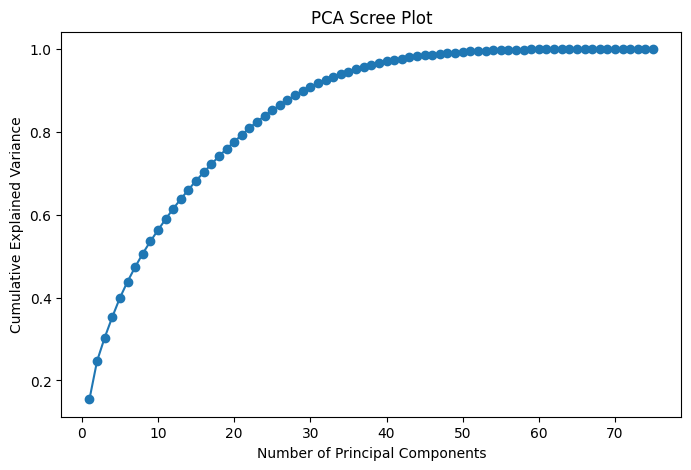

In [109]:
features = [col for col in df.columns if col not in ["car_ID", "CarName"]]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 完整 PCA，用于碎石图
pca_full = PCA()
pca_full.fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.show()

In [110]:
pca = PCA(n_components=16, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Number of principal components retained: {X_pca.shape[1]}")

pc_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca.to_csv("PCA/car_price_pca.csv", index=False)
print("Saved PCA results to PCA/car_price_pca.csv")

Number of principal components retained: 16
Saved PCA results to PCA/car_price_pca.csv


**AE**

Epoch [10/1500], Loss: 0.5027
Epoch [20/1500], Loss: 0.6617
Epoch [30/1500], Loss: 0.2193
Epoch [40/1500], Loss: 0.1572
Epoch [50/1500], Loss: 0.1505
Epoch [60/1500], Loss: 0.0998
Epoch [70/1500], Loss: 0.0626
Epoch [80/1500], Loss: 0.0398
Epoch [90/1500], Loss: 0.0508
Epoch [100/1500], Loss: 0.0384
Epoch [110/1500], Loss: 0.0736
Epoch [120/1500], Loss: 0.0249
Epoch [130/1500], Loss: 0.0225
Epoch [140/1500], Loss: 0.0343
Epoch [150/1500], Loss: 0.0312
Epoch [160/1500], Loss: 0.0234
Epoch [170/1500], Loss: 0.0232
Epoch [180/1500], Loss: 0.0215
Epoch [190/1500], Loss: 0.0182
Epoch [200/1500], Loss: 0.0202
Epoch [210/1500], Loss: 0.0118
Epoch [220/1500], Loss: 0.0098
Epoch [230/1500], Loss: 0.0164
Epoch [240/1500], Loss: 0.0119
Epoch [250/1500], Loss: 0.0139
Epoch [260/1500], Loss: 0.0085
Epoch [270/1500], Loss: 0.0110
Epoch [280/1500], Loss: 0.0106
Epoch [290/1500], Loss: 0.0094
Epoch [300/1500], Loss: 0.0105
Epoch [310/1500], Loss: 0.0073
Epoch [320/1500], Loss: 0.0099
Epoch [330/1500],

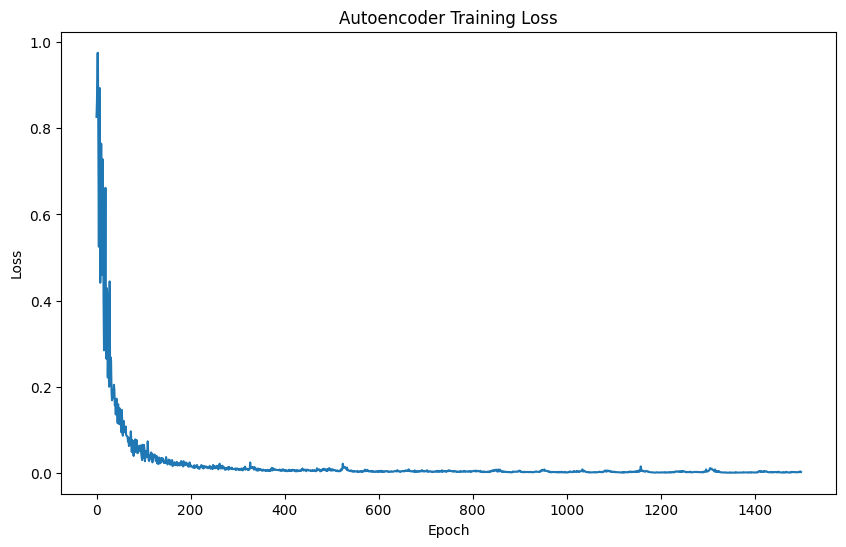

In [111]:
X_tensor = torch.FloatTensor(X_scaled)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize model, loss function, and optimizer
model = Autoencoder(X_scaled.shape[1], 32)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1500
losses = []

for epoch in range(num_epochs):
    for data, _ in dataloader:
        # Forward pass
        encoded, decoded = model(data)
        loss = criterion(decoded, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get encoded representations
model.eval()
with torch.no_grad():
    encoded_data, _ = model(X_tensor)
    encoded_data = encoded_data.numpy()

# Save encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'AE_{i+1}' for i in range(encoded_data.shape[1])])
encoded_df.to_csv('AE/car_price_ae.csv', index=False)

**SAE**

Pretraining individual autoencoders...

Pretraining autoencoder 1
Epoch [20/500], Loss: 0.2774
Epoch [40/500], Loss: 0.1026
Epoch [60/500], Loss: 0.0638
Epoch [80/500], Loss: 0.0284
Epoch [100/500], Loss: 0.0417
Epoch [120/500], Loss: 0.0436
Epoch [140/500], Loss: 0.0255
Epoch [160/500], Loss: 0.0229
Epoch [180/500], Loss: 0.0276
Epoch [200/500], Loss: 0.0187
Epoch [220/500], Loss: 0.0134
Epoch [240/500], Loss: 0.0105
Epoch [260/500], Loss: 0.0080
Epoch [280/500], Loss: 0.0087
Epoch [300/500], Loss: 0.0084
Epoch [320/500], Loss: 0.0115
Epoch [340/500], Loss: 0.0073
Epoch [360/500], Loss: 0.0062
Epoch [380/500], Loss: 0.0130
Epoch [400/500], Loss: 0.0070
Epoch [420/500], Loss: 0.0048
Epoch [440/500], Loss: 0.0050
Epoch [460/500], Loss: 0.0069
Epoch [480/500], Loss: 0.0069
Epoch [500/500], Loss: 0.0055

Pretraining autoencoder 2
Epoch [20/500], Loss: 0.4745
Epoch [40/500], Loss: 0.1400
Epoch [60/500], Loss: 0.1097
Epoch [80/500], Loss: 0.0492
Epoch [100/500], Loss: 0.0406
Epoch [120/500]

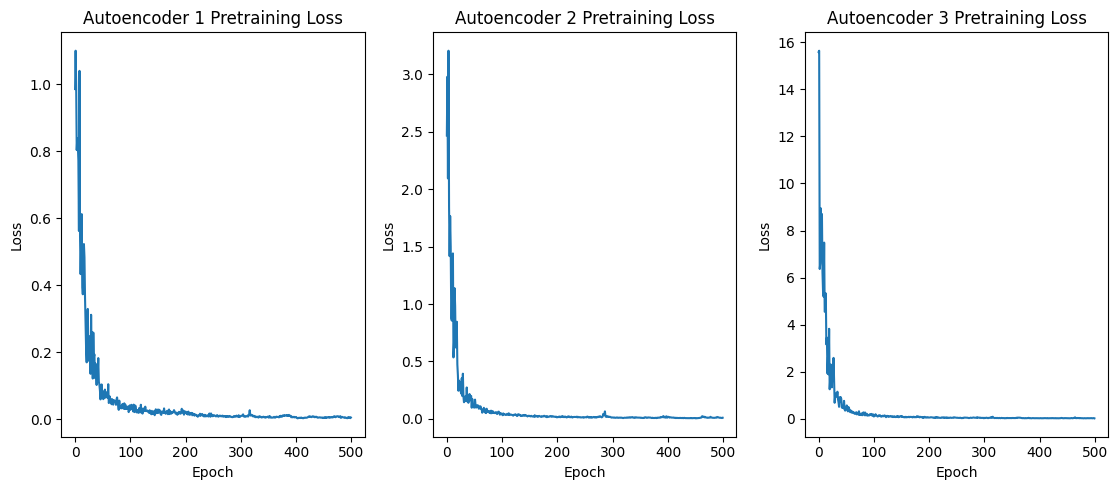


Fine-tuning complete model...
Epoch [10/1500], Loss: 0.0040
Epoch [20/1500], Loss: 0.0027
Epoch [30/1500], Loss: 0.0033
Epoch [40/1500], Loss: 0.0047
Epoch [50/1500], Loss: 0.0038
Epoch [60/1500], Loss: 0.0050
Epoch [70/1500], Loss: 0.0041
Epoch [80/1500], Loss: 0.0026
Epoch [90/1500], Loss: 0.0041
Epoch [100/1500], Loss: 0.0033
Epoch [110/1500], Loss: 0.0021
Epoch [120/1500], Loss: 0.0023
Epoch [130/1500], Loss: 0.0022
Epoch [140/1500], Loss: 0.0047
Epoch [150/1500], Loss: 0.0027
Epoch [160/1500], Loss: 0.0028
Epoch [170/1500], Loss: 0.0023
Epoch [180/1500], Loss: 0.0026
Epoch [190/1500], Loss: 0.0026
Epoch [200/1500], Loss: 0.0029
Epoch [210/1500], Loss: 0.0031
Epoch [220/1500], Loss: 0.0033
Epoch [230/1500], Loss: 0.0029
Epoch [240/1500], Loss: 0.0025
Epoch [250/1500], Loss: 0.0021
Epoch [260/1500], Loss: 0.0024
Epoch [270/1500], Loss: 0.0040
Epoch [280/1500], Loss: 0.0038
Epoch [290/1500], Loss: 0.0023
Epoch [300/1500], Loss: 0.0035
Epoch [310/1500], Loss: 0.0022
Epoch [320/1500],

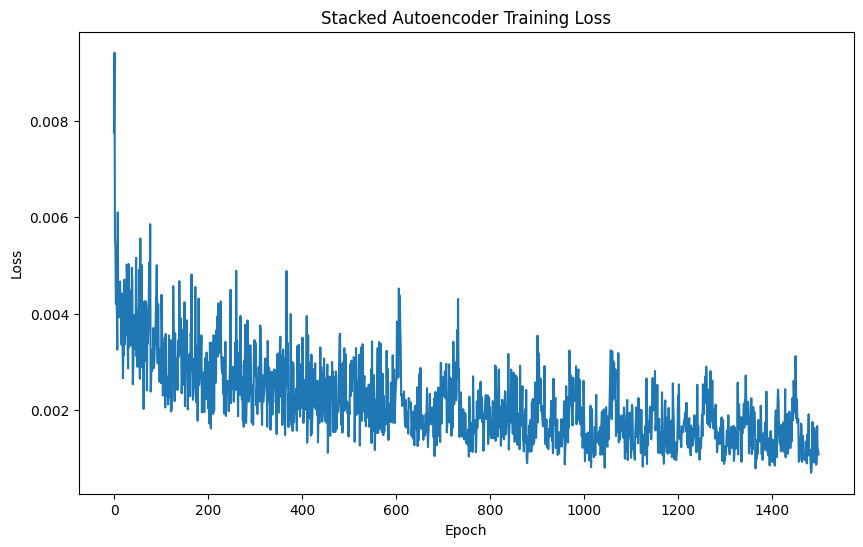

In [112]:
class StackedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dims):
        super(StackedAutoencoder, self).__init__()
        self.autoencoders = nn.ModuleList()
        
        # Create stack of autoencoders
        curr_dim = input_dim
        for encoding_dim in encoding_dims:
            self.autoencoders.append(Autoencoder(curr_dim, encoding_dim))
            curr_dim = encoding_dim
            
    def forward(self, x):
        encoded = x
        encoded_features = []
        for autoencoder in self.autoencoders:
            encoded = autoencoder.encoder(encoded)
            encoded_features.append(encoded)
            
        # Decode in reverse order
        decoded = encoded
        for autoencoder in reversed(self.autoencoders):
            decoded = autoencoder.decoder(decoded)
            
        return decoded, encoded_features

encoding_dims = [128, 64, 32]  # Progressive reduction in dimensions

model = StackedAutoencoder(X_scaled.shape[1], encoding_dims)
criterion = nn.MSELoss()

# Pretrain each autoencoder layer
print("Pretraining individual autoencoders...")
curr_input = X_tensor
pretrain_losses = []  # To store losses for each autoencoder
for i, autoencoder in enumerate(model.autoencoders):
    print(f"\nPretraining autoencoder {i+1}")
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    
    pretrain_epochs = 500
    losses = []  # Store losses for the current autoencoder
    for epoch in range(pretrain_epochs):
        for data, _ in dataloader:
            if i > 0:
                with torch.no_grad():
                    for j in range(i):
                        data = model.autoencoders[j].encoder(data)
            
            encoded = autoencoder.encoder(data)
            decoded = autoencoder.decoder(encoded)
            loss = criterion(decoded, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{pretrain_epochs}], Loss: {loss.item():.4f}')
    
    pretrain_losses.append(losses)  # Store losses for plotting

# Plot pretraining losses for each autoencoder
plt.figure(figsize=(15, 5))
for i, losses in enumerate(pretrain_losses):
    plt.subplot(1, 4, i + 1)
    plt.plot(losses)
    plt.title(f'Autoencoder {i + 1} Pretraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.tight_layout()
plt.show()

# Fine-tune the entire model
print("\nFine-tuning complete model...")
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 1500
losses = []

for epoch in range(num_epochs):
    for data, _ in dataloader:
        decoded, encoded_features = model(data)
        loss = criterion(decoded, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Stacked Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get encoded representations (using the final encoding layer)
model.eval()
with torch.no_grad():
    _, encoded_features = model(X_tensor)
    # Get the final encoded representation (32 dimensions)
    encoded_data = encoded_features[-1].numpy()

# Save encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'SAE_{i+1}' for i in range(encoded_data.shape[1])])
encoded_df.to_csv('SAE/car_price_sae.csv', index=False)